<a href="https://colab.research.google.com/github/macscheffer/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=37.83147459746415, mobile=True), User(purchased=True, time_on_site=297.3760340574865, mobile=True), User(purchased=False, time_on_site=170.27322654263193, mobile=True), User(purchased=False, time_on_site=187.4028623907486, mobile=True), User(purchased=True, time_on_site=78.85190300373333, mobile=True), User(purchased=False, time_on_site=54.52394171181303, mobile=True), User(purchased=False, time_on_site=58.69209574796728, mobile=True), User(purchased=False, time_on_site=7.04429560483984, mobile=True), User(purchased=False, time_on_site=175.00274031166708, mobile=False), User(purchased=True, time_on_site=35.30834596676843, mobile=True)]


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,37.831475,True
1,True,297.376034,True
2,False,170.273227,True
3,False,187.402862,True
4,True,78.851903,True


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.339383697685621,5.394155586211019,5.841963075183767,6.726171627185764,6.772109567525894,6.853538565484358,6.973395563092575,7.04429560483984,7.073654370217446,7.176960592900681,...,578.6471133701842,581.6339400063836,582.4490883209,585.3654702081399,591.9387207642812,592.6277843653963,596.3010910445763,596.905457639525,597.4231790667909,599.357239514557
purchased,,,,,,,,,,,,,,,,,,,,,
False,0,1,0,1,1,0,1,1,1,1,...,1,0,0,0,0,0,0,0,1,0
True,1,0,1,0,0,1,0,0,0,0,...,0,1,1,1,1,1,1,1,0,1


In [0]:
pd.crosstab(user_data['purchased'], user_data['mobile'],
            normalize='columns')

mobile,False,True
purchased,,
False,0.704,0.570667
True,0.296,0.429333


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.745, 124.143]","(124.143, 242.947]","(242.947, 361.75]","(361.75, 480.554]","(480.554, 599.357]"
purchased,,,,,
False,233,209,107,36,19
True,109,145,100,18,24


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.621, 123.202]","(123.202, 241.192]","(241.192, 359.183]","(359.183, 477.174]","(477.174, 595.165]"
purchased,,,,,
False,0.811321,0.832877,0.885572,0.86,0.909091
True,0.188679,0.167123,0.114428,0.14,0.090909


In [0]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.912,0.82
True,0.088,0.18


In [2]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

user_data.head()

df = pd.cut(user_data['time_on_site'], 5)
user_data['bin'] = df

for b in user_data.bin.unique():
  print(df[df.bin == b].describe())

NameError: ignored

In [0]:
user_data.head()

,purchased,time_on_site,mobile,bin
0,False,37.831475,True,"(4.745, 124.143]"
1,True,297.376034,True,"(242.947, 361.75]"
2,False,170.273227,True,"(124.143, 242.947]"
3,False,187.402862,True,"(124.143, 242.947]"
4,True,78.851903,True,"(4.745, 124.143]"


In [0]:
series = pd.cut(user_data['time_on_site'], 5)
user_data['bin'] = series

for b in user_data.bin.unique():
  print(user_data[user_data.bin == b].head())

   purchased  time_on_site  mobile               bin
0      False     37.831475    True  (4.745, 124.143]
4       True     78.851903    True  (4.745, 124.143]
5      False     54.523942    True  (4.745, 124.143]
6      False     58.692096    True  (4.745, 124.143]
7      False      7.044296    True  (4.745, 124.143]
    purchased  time_on_site  mobile                bin
1        True    297.376034    True  (242.947, 361.75]
15      False    321.759360   False  (242.947, 361.75]
17       True    298.148660    True  (242.947, 361.75]
21      False    271.358613    True  (242.947, 361.75]
30       True    271.831635    True  (242.947, 361.75]
    purchased  time_on_site  mobile                 bin
2       False    170.273227    True  (124.143, 242.947]
3       False    187.402862    True  (124.143, 242.947]
8       False    175.002740   False  (124.143, 242.947]
10      False    186.550986    True  (124.143, 242.947]
13       True    240.153493    True  (124.143, 242.947]
     purchased  

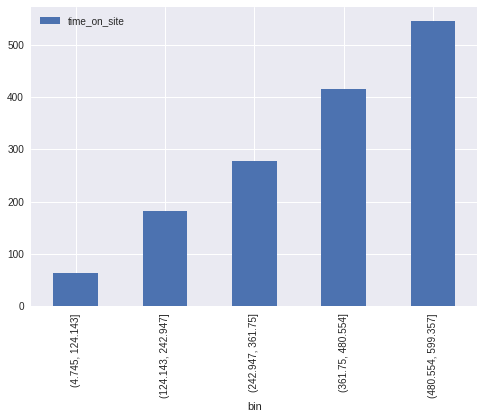

In [0]:
pd.pivot_table(user_data,values='time_on_site',index='bin').plot.bar()
pd.pivot_table(user_data,values='purchased',index='bin').plot.bar()

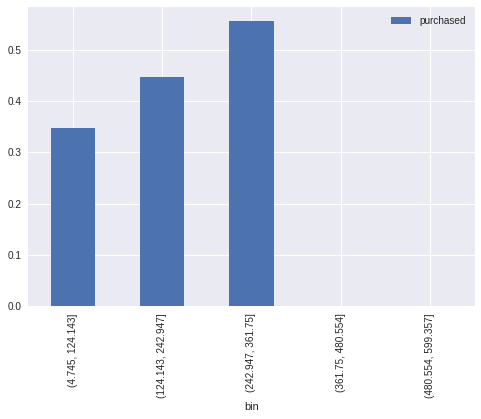

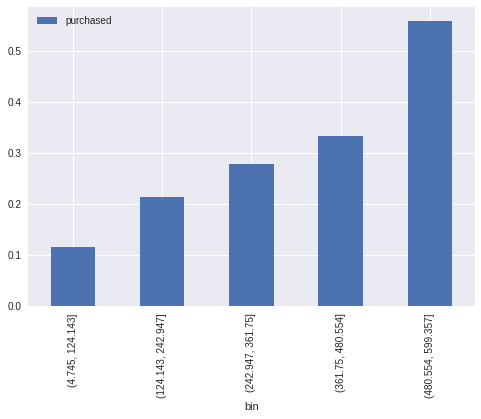

In [0]:
pd.pivot_table(user_data[user_data.mobile == True],values='purchased',index='bin').plot.bar()
pd.pivot_table(user_data[user_data.mobile == False],values='purchased',index='bin').plot.bar()

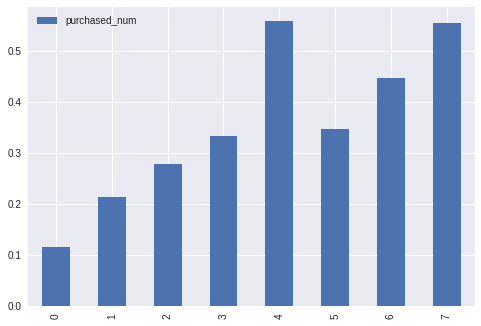

In [0]:
user_data['purchased_num'] = user_data['purchased'] * 1
df = user_data.groupby(['mobile', 'bin'])['purchased_num'].mean()
df = df.reset_index()
df.plot.bar()

In [0]:
# groupby()

grouped_data = user_data.mobile.groupby(user_data.purchased)
len(grouped_data)

2

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [4]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/macscheffer/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv')
df.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [5]:
df.columns

Index(['Unnamed: 0', 'age', 'weight', 'exercise_time'], dtype='object')

In [6]:
df.corr()

,Unnamed: 0,age,weight,exercise_time
Unnamed: 0,1.000000,-0.000418,-0.060297,-0.020138
age,-0.000418,1.000000,0.144168,-0.273818
weight,-0.060297,0.144168,1.000000,-0.478021
exercise_time,-0.020138,-0.273818,-0.478021,1.000000


In [7]:
df.describe()

,Unnamed: 0,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,599.500000,48.396667,153.540833,134.910833
std,346.554469,18.166802,35.132182,85.548895
min,0.000000,18.000000,100.000000,0.000000
25%,299.750000,33.000000,125.000000,65.000000
50%,599.500000,48.000000,149.000000,122.000000
75%,899.250000,64.000000,180.250000,206.000000
max,1199.000000,80.000000,246.000000,300.000000


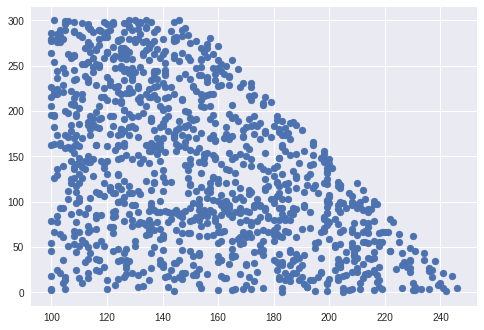

In [8]:
import matplotlib.pyplot as plt

plt.scatter(df.weight,df.exercise_time)

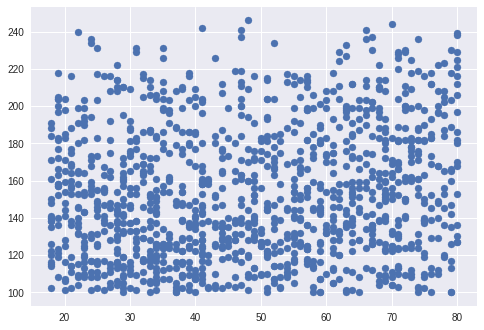

In [9]:
plt.scatter(df.age,df.weight)

In [10]:
age_bins = pd.cut(df['age'],bins=6)
type(age_bins)

pandas.core.series.Series

In [0]:
df['age_bins'] = age_bins

In [12]:
(df.groupby(by=df.age_bins))

In [13]:
lst_of_dfs = []

for age_bin in list(age_bins.unique()):
  lst_of_dfs.append(df[df['age_bins'] == age_bin])

len(lst_of_dfs)

6

In [14]:
for sdf in lst_of_dfs:
  print(sdf.describe())

        Unnamed: 0         age      weight  exercise_time
count   200.000000  200.000000  200.000000     200.000000
mean    587.455000   43.790000  149.855000     159.730000
std     338.114128    3.375332   34.406146      90.724926
min       0.000000   39.000000  100.000000       1.000000
25%     304.000000   41.000000  125.000000      80.000000
50%     576.500000   44.000000  140.000000     162.500000
75%     864.250000   47.000000  172.000000     245.500000
max    1195.000000   49.000000  246.000000     300.000000
        Unnamed: 0         age      weight  exercise_time
count   209.000000  209.000000  209.000000     209.000000
mean    606.062201   22.933014  150.215311     152.483254
std     345.908073    3.248566   33.445946      81.226186
min       4.000000   18.000000  101.000000       0.000000
25%     323.000000   20.000000  122.000000      85.000000
50%     622.000000   23.000000  145.000000     156.000000
75%     902.000000   26.000000  171.000000     219.000000
max    1198.00

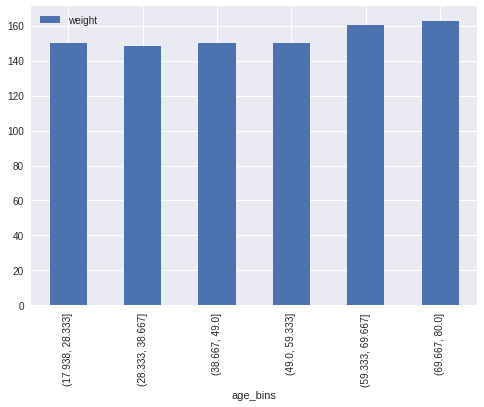

In [15]:
df.pivot_table(index='age_bins', values='weight').plot.bar()

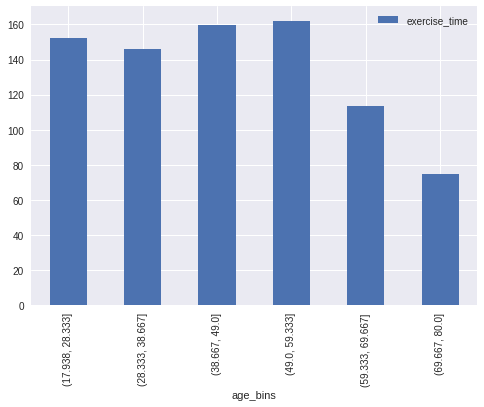

In [16]:
df.pivot_table(index='age_bins', values='exercise_time').plot.bar()

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

def black_box(dfs, features):    # input a list of dfs and list of features.
  
  errors = {}
  
  for df in dfs:
    
    train, test = train_test_split(df.copy())
    
    # initializing our linear regression object and fitting it.
    model = LinearRegression()
    model.fit(train[features], train['weight'])
    
    # predicting both in sample and out of sample weights using our model.
    isp = model.predict(train[features])
    oosp = model.predict(test[features])
    
    # getting our errors
    in_sample_error = mean_absolute_error(train['weight'], isp)
    out_of_sample_error = mean_absolute_error(test['weight'], oosp)
    
    errors['in_sample_error' + str(round(df.age.mean(), 2))] = in_sample_error
    errors['out_of_sample_error' + str(round(df.age.mean(), 2))] = out_of_sample_error
    
  return errors

In [0]:
features = ['age', 'weight', 'exercise_time']

In [0]:
results = black_box(dfs=lst_of_dfs, features=features)

In [20]:
results = pd.Series(results)
results.shape

(12,)

In [21]:
results

in_sample_error22.93        1.994985e-14
in_sample_error33.35        1.219326e-14
in_sample_error43.79        2.065311e-14
in_sample_error54.69        2.450858e-14
in_sample_error64.85        1.075683e-14
in_sample_error74.62        1.968395e-14
out_of_sample_error22.93    1.903718e-14
out_of_sample_error33.35    1.188544e-14
out_of_sample_error43.79    2.074785e-14
out_of_sample_error54.69    2.934850e-14
out_of_sample_error64.85    1.421085e-14
out_of_sample_error74.62    2.273737e-14
dtype: float64

In [0]:
new_ser = list(results.index)

In [0]:
new_ser = pd.Series(new_ser)

In [0]:
dic = {1: results[0], 2: new_ser}
results_df = pd.DataFrame(dic)

In [25]:
results_df

,1,2
0,1.994985e-14,in_sample_error22.93
1,1.994985e-14,in_sample_error33.35
2,1.994985e-14,in_sample_error43.79
3,1.994985e-14,in_sample_error54.69
4,1.994985e-14,in_sample_error64.85
5,1.994985e-14,in_sample_error74.62
6,1.994985e-14,out_of_sample_error22.93
7,1.994985e-14,out_of_sample_error33.35
8,1.994985e-14,out_of_sample_error43.79
9,1.994985e-14,out_of_sample_error54.69


In [26]:
df.dtypes

Unnamed: 0          int64
age                 int64
weight              int64
exercise_time       int64
age_bins         category
dtype: object

In [27]:
df.head()

,Unnamed: 0,age,weight,exercise_time,age_bins
0,0,44,118,192,"(38.667, 49.0]"
1,1,41,161,35,"(38.667, 49.0]"
2,2,46,128,220,"(38.667, 49.0]"
3,3,39,216,57,"(38.667, 49.0]"
4,4,28,116,182,"(17.938, 28.333]"


In [37]:
grouped_df = df.groupby('age_bins')
descriptive_df = grouped_df['weight'].corr(df['exercise_time'])
type(descriptive_df)

pandas.core.series.Series

In [41]:
type(descriptive_df)

pandas.core.frame.DataFrame

In [42]:
descriptive_df.head()

,weight
age_bins,
"(17.938, 28.333]",-0.531099
"(28.333, 38.667]",-0.470117
"(38.667, 49.0]",-0.568483
"(49.0, 59.333]",-0.482434
"(59.333, 69.667]",-0.454645


In [44]:
descriptive_df.rename_axis(['weight_exercise_corr'])

,weight
weight_exercise_corr,
"(17.938, 28.333]",-0.531099
"(28.333, 38.667]",-0.470117
"(38.667, 49.0]",-0.568483
"(49.0, 59.333]",-0.482434
"(59.333, 69.667]",-0.454645
"(69.667, 80.0]",-0.224981


In [51]:
descriptive_df.rename({'weight':'weight_exercise_corr'},axis='columns',inplace=True)
descriptive_df.head()

,weight_exercise_corr
age_bins,
"(17.938, 28.333]",-0.531099
"(28.333, 38.667]",-0.470117
"(38.667, 49.0]",-0.568483
"(49.0, 59.333]",-0.482434
"(59.333, 69.667]",-0.454645


In [55]:
descriptive_df['weight_age_corr'] = grouped_df['weight'].corr(df['age'])
descriptive_df.head()

,weight_exercise_corr,weight_age_corr
age_bins,,
"(17.938, 28.333]",-0.531099,-0.052567
"(28.333, 38.667]",-0.470117,-0.025240
"(38.667, 49.0]",-0.568483,0.089264
"(49.0, 59.333]",-0.482434,0.038248
"(59.333, 69.667]",-0.454645,0.042757


In [60]:
groups = dict(list(grouped_df))
print(len(groups))

6


In [73]:
list([key for key in groups])

[Interval(17.938, 28.333, closed='right'),
 Interval(28.333, 38.667, closed='right'),
 Interval(38.667, 49.0, closed='right'),
 Interval(49.0, 59.333, closed='right'),
 Interval(59.333, 69.667, closed='right'),
 Interval(69.667, 80.0, closed='right')]

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


1. The datatypes are all integer. 
2. In general: as age goes up exercise time goes down, as age goes up weight goes up. As exercise time goes down, weight goes up. 
3. I think exercise time and weight are somewhat spurious. People may exercise because more because they are overweight or vice versa. As people age, they tend to gain weight. The table below does a good job representing this.

In [0]:
df.groupby('age_bins').mean()

,Unnamed: 0,age,weight,exercise_time
age_bins,,,,
"(17.938, 28.333]",606.062201,22.933014,150.215311,152.483254
"(28.333, 38.667]",595.543779,33.350230,148.271889,145.926267
"(38.667, 49.0]",587.455000,43.790000,149.855000,159.730000
"(49.0, 59.333]",623.978261,54.690217,150.211957,162.103261
"(59.333, 69.667]",592.427083,64.848958,160.588542,113.458333
"(69.667, 80.0]",593.186869,74.616162,162.808081,74.752525


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)

In [0]:
# going to try and work with NFL data https://github.com/nfl-football-ops/Big-Data-Bowl/tree/master/Data

games = pd.read_csv('https://raw.githubusercontent.com/nfl-football-ops/Big-Data-Bowl/master/Data/games.csv')
players = pd.read_csv('https://raw.githubusercontent.com/nfl-football-ops/Big-Data-Bowl/master/Data/players.csv')
plays = pd.read_csv('https://raw.githubusercontent.com/nfl-football-ops/Big-Data-Bowl/master/Data/plays.csv')

In [77]:
print(games.columns)

Index(['season', 'week', 'gameDate', 'gameId', 'gameTimeEastern', 'HomeScore',
       'VisitorScore', 'homeTeamAbbr', 'visitorTeamAbbr', 'homeDisplayName',
       'visitorDisplayName', 'Stadium', 'Location', 'StadiumType', 'Turf',
       'GameLength', 'GameWeather', 'Temperature', 'Humidity', 'WindSpeed',
       'WindDirection'],
      dtype='object')


In [78]:
print(players.columns)

Index(['nflId', 'FirstName', 'LastName', 'PositionAbbr', 'EntryYear',
       'DraftRound', 'DraftNumber', 'Height', 'Weight', 'College'],
      dtype='object')


In [79]:
print(plays.columns)

Index(['gameId', 'playId', 'quarter', 'GameClock', 'down', 'yardsToGo',
       'possessionTeam', 'yardlineSide', 'yardlineNumber', 'offenseFormation',
       'personnel.offense', 'defendersInTheBox', 'numberOfPassRushers',
       'personnel.defense', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'HomeScoreAfterPlay', 'VisitorScoreAfterPlay', 'isPenalty', 'isSTPlay',
       'SpecialTeamsPlayType', 'KickReturnYardage', 'PassLength', 'PassResult',
       'YardsAfterCatch', 'PlayResult', 'playDescription'],
      dtype='object')


In [80]:
plays.head()

,gameId,playId,quarter,GameClock,down,yardsToGo,possessionTeam,yardlineSide,yardlineNumber,offenseFormation,...,VisitorScoreAfterPlay,isPenalty,isSTPlay,SpecialTeamsPlayType,KickReturnYardage,PassLength,PassResult,YardsAfterCatch,PlayResult,playDescription
0,2017091004,37,1,15:00:00,0,0,DET,DET,35.0,NaN,...,0,False,True,Kickoff,23.0,NaN,NaN,NaN,42,K.Redfern kicks 65 yards from DET 35 to ARZ 0....
1,2017091004,73,1,14:54:00,1,10,ARI,ARI,23.0,SHOTGUN,...,0,False,False,NaN,NaN,-2.0,C,6.0,4,(14:54) (Shotgun) C.Palmer pass short right to...
2,2017091004,97,1,14:16:00,2,6,ARI,ARI,27.0,SINGLEBACK,...,0,False,False,NaN,NaN,NaN,NaN,NaN,2,(14:16) Da.Johnson up the middle to ARZ 29 for...
3,2017091004,118,1,13:34:00,3,4,ARI,ARI,29.0,SHOTGUN,...,0,False,False,NaN,NaN,7.0,C,7.0,15,(13:34) (Shotgun) C.Palmer pass short middle t...
4,2017091004,153,1,12:51:00,1,10,ARI,ARI,44.0,SHOTGUN,...,0,False,False,NaN,NaN,NaN,NaN,NaN,-2,(12:51) (Shotgun) Da.Johnson left end to ARZ 4...


In [81]:
plays.shape

(14193, 27)

In [82]:
len(list(plays.gameId.unique()))

91

In [0]:
gameIds = list(plays.gameId.unique())

In [84]:
gameIds[0]

2017091004

In [85]:
len(list(games.gameId))

91

In [0]:
plays = pd.merge(plays, games, on='gameId')

In [88]:
plays.columns

Index(['gameId', 'playId', 'quarter', 'GameClock', 'down', 'yardsToGo',
       'possessionTeam', 'yardlineSide', 'yardlineNumber', 'offenseFormation',
       'personnel.offense', 'defendersInTheBox', 'numberOfPassRushers',
       'personnel.defense', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'HomeScoreAfterPlay', 'VisitorScoreAfterPlay', 'isPenalty', 'isSTPlay',
       'SpecialTeamsPlayType', 'KickReturnYardage', 'PassLength', 'PassResult',
       'YardsAfterCatch', 'PlayResult', 'playDescription', 'season', 'week',
       'gameDate', 'gameTimeEastern', 'HomeScore', 'VisitorScore',
       'homeTeamAbbr', 'visitorTeamAbbr', 'homeDisplayName',
       'visitorDisplayName', 'Stadium', 'Location', 'StadiumType', 'Turf',
       'GameLength', 'GameWeather', 'Temperature', 'Humidity', 'WindSpeed',
       'WindDirection'],
      dtype='object')

In [89]:
list(plays.homeTeamAbbr.unique())

['DET',
 'NE',
 'CLE',
 'CIN',
 'BUF',
 'CHI',
 'TEN',
 'WAS',
 'HOU',
 'GB',
 'LA',
 'SF',
 'DAL',
 'MIN',
 'CAR',
 'KC',
 'NO',
 'IND',
 'NYJ',
 'JAX',
 'TB',
 'LAC',
 'BAL',
 'DEN',
 'ATL',
 'OAK',
 'SEA',
 'PIT',
 'NYG',
 'PHI',
 'MIA',
 'ARI']

In [92]:
plays[plays['gameId'] == gameIds[0]].head()

,gameId,playId,quarter,GameClock,down,yardsToGo,possessionTeam,yardlineSide,yardlineNumber,offenseFormation,...,Stadium,Location,StadiumType,Turf,GameLength,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017091004,37,1,15:00:00,0,0,DET,DET,35.0,NaN,...,Ford Field,"Detroit, MI",Indoors,Field Turf,03:26:00,Controlled Climate,68.0,70.0,NaN,NaN
1,2017091004,73,1,14:54:00,1,10,ARI,ARI,23.0,SHOTGUN,...,Ford Field,"Detroit, MI",Indoors,Field Turf,03:26:00,Controlled Climate,68.0,70.0,NaN,NaN
2,2017091004,97,1,14:16:00,2,6,ARI,ARI,27.0,SINGLEBACK,...,Ford Field,"Detroit, MI",Indoors,Field Turf,03:26:00,Controlled Climate,68.0,70.0,NaN,NaN
3,2017091004,118,1,13:34:00,3,4,ARI,ARI,29.0,SHOTGUN,...,Ford Field,"Detroit, MI",Indoors,Field Turf,03:26:00,Controlled Climate,68.0,70.0,NaN,NaN
4,2017091004,153,1,12:51:00,1,10,ARI,ARI,44.0,SHOTGUN,...,Ford Field,"Detroit, MI",Indoors,Field Turf,03:26:00,Controlled Climate,68.0,70.0,NaN,NaN


In [0]:
game_summary = {}
gameIds = list(plays.gameId.unique())
for g in gameIds:
  game = plays[plays['gameId'] == g]
  game = game[game['isSTPlay'] == False]
  home_ball = game[game['possessionTeam'] == game['homeTeamAbbr']]
  away_ball = game[game['possessionTeam'] == game['visitorTeamAbbr']]
  game_summary['home_yards'] = home_ball['PlayResult'].sum()

In [105]:
print(game_summary)

{'home_yards': 295}


In [94]:
plays.isSTPlay

0         True
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9         True
10        True
11       False
12       False
13       False
14        True
15       False
16       False
17       False
18        True
19       False
20       False
21       False
22        True
23       False
24       False
25       False
26        True
27       False
28       False
29       False
         ...  
14163     True
14164    False
14165    False
14166    False
14167     True
14168    False
14169     True
14170    False
14171    False
14172    False
14173     True
14174    False
14175     True
14176    False
14177    False
14178    False
14179    False
14180     True
14181    False
14182    False
14183    False
14184     True
14185    False
14186    False
14187    False
14188    False
14189    False
14190    False
14191    False
14192     True
Name: isSTPlay, Length: 14193, dtype: bool

In [99]:
plays['gameId'].unique()

array([2017091004, 2017090700, 2017091003, 2017091002, 2017091000,
       2017091001, 2017091007, 2017091008, 2017091005, 2017091010,
       2017091009, 2017091011, 2017091012, 2017091100, 2017091701,
       2017091704, 2017091705, 2017091702, 2017092408, 2017091703,
       2017091707, 2017091708, 2017091700, 2017091101, 2017091711,
       2017091713, 2017092407, 2017091709, 2017092400, 2017091712,
       2017091400, 2017091706, 2017091710, 2017091800, 2017092100,
       2017092404, 2017092401, 2017092412, 2017100104, 2017092413,
       2017100102, 2017100106, 2017092402, 2017092406, 2017092410,
       2017100107, 2017092403, 2017092409, 2017092405, 2017100100,
       2017092411, 2017092800, 2017100101, 2017092500, 2017100108,
       2017100105, 2017100109, 2017100111, 2017100802, 2017100803,
       2017100801, 2017100809, 2017100112, 2017100805, 2017100807,
       2017100811, 2017100103, 2017100500, 2017100806, 2017100810,
       2017100113, 2017100110, 2017100800, 2017100804, 2017100

In [100]:
gameIds

[2017091004,
 2017090700,
 2017091003,
 2017091002,
 2017091000,
 2017091001,
 2017091007,
 2017091008,
 2017091005,
 2017091010,
 2017091009,
 2017091011,
 2017091012,
 2017091100,
 2017091701,
 2017091704,
 2017091705,
 2017091702,
 2017092408,
 2017091703,
 2017091707,
 2017091708,
 2017091700,
 2017091101,
 2017091711,
 2017091713,
 2017092407,
 2017091709,
 2017092400,
 2017091712,
 2017091400,
 2017091706,
 2017091710,
 2017091800,
 2017092100,
 2017092404,
 2017092401,
 2017092412,
 2017100104,
 2017092413,
 2017100102,
 2017100106,
 2017092402,
 2017092406,
 2017092410,
 2017100107,
 2017092403,
 2017092409,
 2017092405,
 2017100100,
 2017092411,
 2017092800,
 2017100101,
 2017092500,
 2017100108,
 2017100105,
 2017100109,
 2017100111,
 2017100802,
 2017100803,
 2017100801,
 2017100809,
 2017100112,
 2017100805,
 2017100807,
 2017100811,
 2017100103,
 2017100500,
 2017100806,
 2017100810,
 2017100113,
 2017100110,
 2017100800,
 2017100804,
 2017100808,
 2017100200,
 2017101511,